In [4]:

import data_loader_utility as dlu
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [321]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [322]:
train_dl, test_dl, val_dl = dlu.get_dataloaders()

Building a model based on this model [here](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/).

In [324]:
class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)  # review wht the different channels are (andrew ng)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)  # default padding is 0, so we need to specify 1 to get the dimensions we want
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flat = nn.Flatten()
        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(343, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        # print(x.shape, 'original')
        x = self.act1(self.conv1(x))
        # print(x.shape, 'after first conv')
        x = self.pool1(x)
        # print(x.shape, 'after 1st maxpool')
        x = self.act2(self.conv2(x))
        # print(x.shape, 'after 2nd conv')
        x = self.pool2(x)
        # print(x.shape, 'after 2nd maxpool')
        x = torch.flatten(x)
        # print(x.shape, 'after flattening')
        x = self.act4(self.fc4(x))
        # print(x.shape, 'after first full connected layer')
        x = self.drop4(x)
        # input 512, output 10
        x = self.fc5(x)
        # print(x.shape, 'last shape after final layer')
        return x


## Extract features from the CNN by specifying which layer to extract them from
We can use code from [here](https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5) to build a feature extractor from our model and use that to get the output of a given layer of our model when it passes over an image.

In [325]:
model = HomemadeCNN()
model.load_state_dict(torch.load('homemademodel.pth'))
model.eval()

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=343, out_features=10, bias=True)
)

In [327]:
def get_features_from_cnn(image):
    # Define a hook to get intermediate layer outputs
    intermediate_outputs = []

    def hook(module, input, output):
        intermediate_outputs.append(output)

    # Register the hook to the desired layer
    hook_handle = model.fc4.register_forward_hook(hook)

    with torch.no_grad():
        output = model(image)

    hook_handle.remove()

    return intermediate_outputs[0].flatten().numpy()

In [328]:
def convert_image_features_using_cnn(data):
    X_ = []
    y_ = []
    for batch in data:
        for img, label in zip(batch[0],batch[1]):
            X_.append(get_features_from_cnn(img))
            y_.append(label)
    return X_, y_

In [329]:
X_train_from_cnn, y_train_from_cnn = convert_image_features_using_cnn(train_dl)
X_test_from_cnn, y_test_from_cnn = convert_image_features_using_cnn(test_dl)

## Fit models with the outputs of the CNN
Using the "synthetic" features generated by the CNN, we can now fit traditional ML models. It would be worthwhile to experiment with taking the outputs from other layers and see how it affects the performance of these models. 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np

Fit a Random Forest classifier to the synthetic features and compare its performance to performance on the unprocessed image data ($343 \times n$), where $n = $ the number of rows in the training set.

accuracy:  0.9092


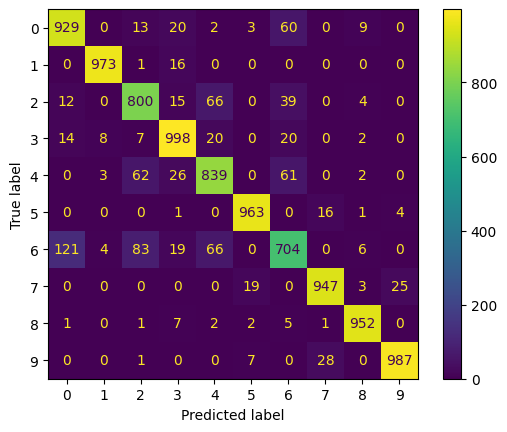

In [331]:
def random_forest(xtrain, xtest, ytrain, ytest):
    """Fit a random forest classifier and display accuracy and confusion matrix."""
    np.random.seed(64)

    rfc = RandomForestClassifier()
    rfc.fit(xtrain, ytrain)
    rf_preds = rfc.predict(xtest)

    # check performance
    print('accuracy: ', metrics.accuracy_score(ytest, rf_preds))
    confmat_rf = metrics.confusion_matrix(ytest, rf_preds)
    show_confmat_rf = metrics.ConfusionMatrixDisplay(confmat_rf)
    show_confmat_rf.plot()
    plt.show()

random_forest(X_train_from_cnn,
              X_test_from_cnn,
              y_train_from_cnn,
              y_test_from_cnn)